# Importing libraries

In [68]:
from kafka import KafkaConsumer
import numpy as np
import pandas as pd
import pickle
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Loading the static data

In [69]:
static_data = pd.read_csv('https://github.com/Mennatallah98/databases/blob/main/Static_dataset.csv')

In [70]:
training_data = static_data.copy(deep=True)

# Data online reading

In [71]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# for m in consumer:
#   print(m.value)
#   break

# Dealing with the data

In [72]:
# divides the data to frames each is of size 1000
frame_no = 0
def get_frame():
  global frame_no
  frame_no+=1
  frame =[]
  i=0
  for m in consumer:
    if frame_no==1 and i==0:
      i+=1
    else:
      frame.append(m.value)
      i+=1
    if i>=1000:
      break
  return frame

In [73]:
#cleans the data from extra characters and puts it in the form dataframe with approprite data type as the static data 
column_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
def clean_data(frames):
    dynamic_data=pd.DataFrame()
    list_of_row=[]
    for frame in frames:
        row_string=eval(frame.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        row[1:6] = [int(x) for x in row[1:6]]
        row[6] = float(row[6])
        row[7:10] = [int(x) for x in row[7:10]]
        row[10] = float(row[10])
        row[13:16] = [int(x) for x in row[13:16]]
        list_of_row.append(row)
    dynamic_data=pd.DataFrame(list_of_row)
    dynamic_data.columns=column_names
    return dynamic_data

In [74]:
# divides the data to features and labels 
def preprocess_data(data):
  data_clean=data.dropna()
  y = data_clean['Target Attack']
  x = data_clean.drop(['Target Attack', 'timestamp'], axis=1)
  return x,y

In [75]:
# add the new data while dropping the old data
def augment_data_replace(frame):
  global training_data
  training_data.drop(training_data.index[1:1000])
  training_data= pd.concat([training_data, frame])


In [76]:
# add the new data without dropping any old data
def augment_data(frame):
  global static_data
  static_data= pd.concat([static_data, frame])


In [77]:
# retraining the dynamic model with the data resukted from augment_data_replace
def retrain_dynamic_model(model):
  x_new, y_new = preprocess_data(training_data)
  model.fit(x_new,y_new)
  return model

In [78]:
# retraining the dynamic model with the data resukted from augment_data_
def retrain_dynamic_model_const(model):
  x_new, y_new = preprocess_data(static_data)
  model.fit(x_new,y_new)
  return model

# Loading the static model

In [80]:
static_pipe= pickle.load(open('static_pipe.pkl', 'rb'))
dynamic_pipe = pickle.load(open('static_pipe.pkl', 'rb'))

# Plotting the model matrices

In [81]:
global static_pres 
global static_recall 
global static_f1 

global dynamic_pres 
global dynamic_recall 
global dynamic_f1 

In [82]:
def plot_model_metrics():
  no_of_frames = [n+1 for n in range(267)]
  # prescision plot
  plt.plot(no_of_frames,static_pres, linewidth=2.0, label='Static mode')
  plt.plot(no_of_frames,dynamic_pres,'--',linewidth=1.0, label='Dynamic model')
  plt.xlabel("Number of frame")
  plt.ylabel("Precision")
  plt.title("Precision over frames for Class 1")
  plt.legend(loc= 'lower right')
  plt.grid(b=True)
  plt.show()
  # Recall plot
  plt.plot(no_of_frames,static_recall, linewidth=2.0,label='Static mode')
  plt.plot(no_of_frames,dynamic_recall,'--',linewidth=1.0, label='Dynamic model')
  plt.xlabel("Number of frame")
  plt.ylabel("Recall")
  plt.title("Recall over frames for Class 1")
  plt.legend(loc= 'lower right')
  plt.grid(b=True)
  plt.show()
  # F1 sscore plot
  plt.plot(no_of_frames,static_f1, linewidth=2.0, label='Static mode')
  plt.plot(no_of_frames,dynamic_f1,'--',linewidth=1.0, label='Dynamic model')
  plt.xlabel("Number of frame")
  plt.ylabel("F1 score")
  plt.title("F1 score over frames for Class 1")
  plt.legend(loc= 'lower right')
  plt.grid(b=True)
  plt.show()

# Comparing the Static and dynamic models

## With data replacement


The model retrained at frame 1
F1 score before retrain 0.8416
F1 score after retrain 0.8142414860681114

The model retrained at frame 2
F1 score before retrain 0.8264840182648402
F1 score after retrain 0.8551181102362205

The model retrained at frame 3
F1 score before retrain 0.8416149068322981
F1 score after retrain 0.8416149068322981

The model retrained at frame 5
F1 score before retrain 0.8452285485164395
F1 score after retrain 0.8405103668261563

The model retrained at frame 7
F1 score before retrain 0.8486692015209125
F1 score after retrain 0.8532110091743119

The model retrained at frame 8
F1 score before retrain 0.8483448806774442
F1 score after retrain 0.8516228748068005

The model retrained at frame 14
F1 score before retrain 0.8459119496855346
F1 score after retrain 0.8465774980330448

The model retrained at frame 17
F1 score before retrain 0.8423529411764706
F1 score after retrain 0.8423529411764706

The model retrained at frame 18
F1 score before retrain 0.836591086786551

C:\Users\Mennatallah\AppData\Local\Temp\ipykernel_19656\3938514334.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


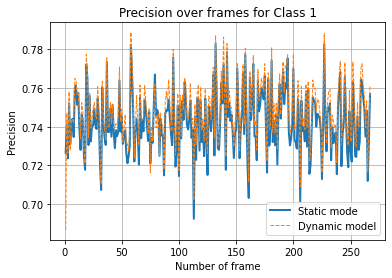

C:\Users\Mennatallah\AppData\Local\Temp\ipykernel_19656\3938514334.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


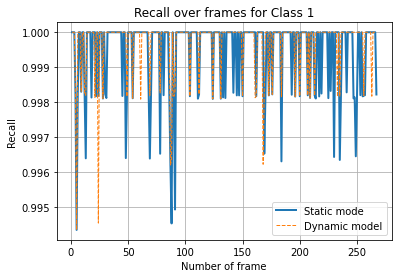

C:\Users\Mennatallah\AppData\Local\Temp\ipykernel_19656\3938514334.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


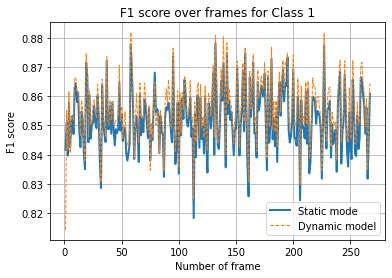

In [67]:
static_pres = []
static_recall = []
static_f1 = []

dynamic_pres = []
dynamic_recall = []
dynamic_f1 = []

for i in range(267):
  new_data = get_frame ()
  data_clean = clean_data(new_data)
  x, y = preprocess_data(data_clean)

  #static model
  y_static_pred = static_pipe.predict(x)
  #getting static model metrices
  static_numbers=precision_recall_fscore_support(y,y_static_pred, average='binary',pos_label=1)
  static_pres.append(static_numbers[0])
  static_recall.append(static_numbers[1])
  static_f1.append(static_numbers[2])

  #dynamic model
  y_dynamic_pred = dynamic_pipe.predict(x)
  #getting dynamic model metrices
  dynamic_numbers=precision_recall_fscore_support(y,y_dynamic_pred, average='binary',pos_label=1)
  
  if dynamic_numbers[2]<0.85:
    print("\nThe model retrained at frame",frame_no)
    print("F1 score before retrain",dynamic_numbers[2])
    dynamic_pipe = retrain_dynamic_model(dynamic_pipe)
    y_dynamic_pred = dynamic_pipe.predict(x)
    #updating dynamic model metrices
    dynamic_numbers=precision_recall_fscore_support(y,y_dynamic_pred, average='binary',pos_label=1)
    print("F1 score after retrain",dynamic_numbers[2])

  dynamic_pres.append(dynamic_numbers[0])
  dynamic_recall.append(dynamic_numbers[1])
  dynamic_f1.append(dynamic_numbers[2])

  augment_data_replace(data_clean)

plot_model_metrics()

## Without data replacement

please run all the previous section except comparing the models section before running the cell


The model retrained at frame 1
F1 score before retrain 0.8416
F1 score after retrain 0.8477034649476228

The model retrained at frame 3
F1 score before retrain 0.8416149068322981
F1 score after retrain 0.8416149068322981

The model retrained at frame 5
F1 score before retrain 0.8452285485164395
F1 score after retrain 0.8452285485164395

The model retrained at frame 14
F1 score before retrain 0.8459119496855346
F1 score after retrain 0.8439215686274509

The model retrained at frame 17
F1 score before retrain 0.841692789968652
F1 score after retrain 0.8423529411764706

The model retrained at frame 18
F1 score before retrain 0.8365910867865519
F1 score after retrain 0.8379013312451057

The model retrained at frame 21
F1 score before retrain 0.846031746031746
F1 score after retrain 0.8094153378891421

The model retrained at frame 22
F1 score before retrain 0.8304182509505703
F1 score after retrain 0.8618784530386739

The model retrained at frame 31
F1 score before retrain 0.84085510688836

C:\Users\Mennatallah\AppData\Local\Temp\ipykernel_19656\3938514334.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


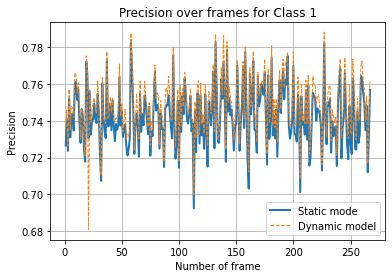

C:\Users\Mennatallah\AppData\Local\Temp\ipykernel_19656\3938514334.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


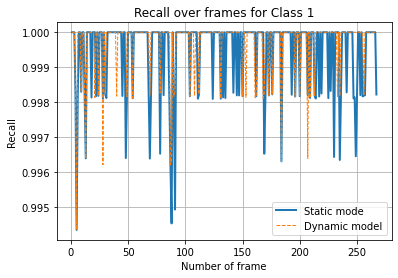

C:\Users\Mennatallah\AppData\Local\Temp\ipykernel_19656\3938514334.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


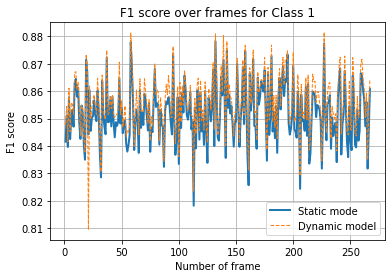

In [83]:
static_pres = []
static_recall = []
static_f1 = []

dynamic_pres = []
dynamic_recall = []
dynamic_f1 = []

for i in range(267):
  new_data = get_frame ()
  data_clean = clean_data(new_data)
  x, y = preprocess_data(data_clean)

  y_static_pred = static_pipe.predict(x)

  #getting static model metrices
  static_numbers=precision_recall_fscore_support(y,y_static_pred, average='binary',pos_label=1)
  static_pres.append(static_numbers[0])
  static_recall.append(static_numbers[1])
  static_f1.append(static_numbers[2])

  #dynamic model
  y_dynamic_pred = dynamic_pipe.predict(x)
  #getting dynamic model metrices
  dynamic_numbers=precision_recall_fscore_support(y,y_dynamic_pred, average='binary',pos_label=1)
  
  if dynamic_numbers[2]<0.85:
    print("\nThe model retrained at frame",frame_no)
    print("F1 score before retrain",dynamic_numbers[2])
    dynamic_pipe = retrain_dynamic_model_const(dynamic_pipe)
    y_dynamic_pred = dynamic_pipe.predict(x)
    #updating dynamic model metrices
    dynamic_numbers=precision_recall_fscore_support(y,y_dynamic_pred, average='binary',pos_label=1)
    print("F1 score after retrain",dynamic_numbers[2])

  dynamic_pres.append(dynamic_numbers[0])
  dynamic_recall.append(dynamic_numbers[1])
  dynamic_f1.append(dynamic_numbers[2])

  augment_data(data_clean)

plot_model_metrics()